In [94]:
from pathlib import Path
import json
import pandas as pd
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import gc # сборщик мусора

In [95]:
gc.collect()

4555

In [96]:
# версия данных
DATA_TAKE_NO = '01_bal_smote'
DATA_PATH = Path('./data/' + DATA_TAKE_NO)

# версия моделей
MODEL_TAKE_NO = '01_bal_smote'
MODEL_PATH = Path('./models/' + MODEL_TAKE_NO)

SCALERS_PATH = Path('./scalers')

# пути
TRAIN_PATH  = DATA_PATH / 'train.csv'
TEST_PATH = DATA_PATH / 'validation.csv'
TRAIN_TARGET_PATH = DATA_PATH / 'train_target.csv'
ТEST_TARGET_PATH = DATA_PATH / 'validation_target.csv'

In [97]:
# загрузить словарь признаков
with open("feature_dict.json", "r") as f:
    feature_dict = json.load(f)
# заполнить признаки по словарю
NUM_FEATURE_NAMES = feature_dict['NUM_FEATURE_NAMES']
CAT_FEATURE_NAMES = feature_dict['CAT_FEATURE_NAMES']
TARGET_NAME = feature_dict['TARGET_NAME']

In [98]:
def get_selected_features():
    drop_feature_list = ['Tax Liens']
    selected_features = NUM_FEATURE_NAMES
    for feature_name in drop_feature_list:
        if feature_name in selected_features:
            selected_features.remove(feature_name)
    return selected_features

In [99]:
# загрузить трейн- и валидационный сеты
X_train = pd.read_csv(TRAIN_PATH)
X_test = pd.read_csv(TEST_PATH)
y_train = pd.read_csv(TRAIN_TARGET_PATH)
y_test =  pd.read_csv(ТEST_TARGET_PATH)

In [100]:
X_test.shape

(3233, 12)

In [101]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    # print('CONFUSION MATRIX\n')
    # print(pd.crosstab(y_test_true, y_test_pred))

In [102]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [103]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

#### XGBoost

In [104]:
import xgboost as xgb

In [105]:
SELECTED_FEATURES = get_selected_features()
# не заводится с категориальными параметрами
X_train_num = X_train[SELECTED_FEATURES]
X_test_num = X_test[SELECTED_FEATURES]

In [106]:
%%time
model_xgb_num = xgb.XGBClassifier(random_state=21, 
                             n_estimators=100,
                             reg_lambda = 0.2,
                             max_depth = 1
                             )
model_xgb_num.fit(X_train_num, y_train)

evaluate_preds(model_xgb_num, X_train_num, X_test_num, y_train, y_test)

C:\Users\kot\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[17:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.75      0.58      0.66      3771
           1       0.66      0.81      0.73      3770

    accuracy                           0.70      7541
   macro avg       0.71      0.70      0.69      7541
weighted avg       0.71      0.70      0.69      7541

TEST

              precision    recall  f1-score   support

           0       0.76      0.56      0.65      1616
           1       0.65      0.82      0.73      1617

    accuracy                           0.69      3233
   macro avg       0.71      0.69      0.69      3233
weighted avg       0.71      0.69      0.69      3233

Wall time: 272 ms


C:\Users\kot\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


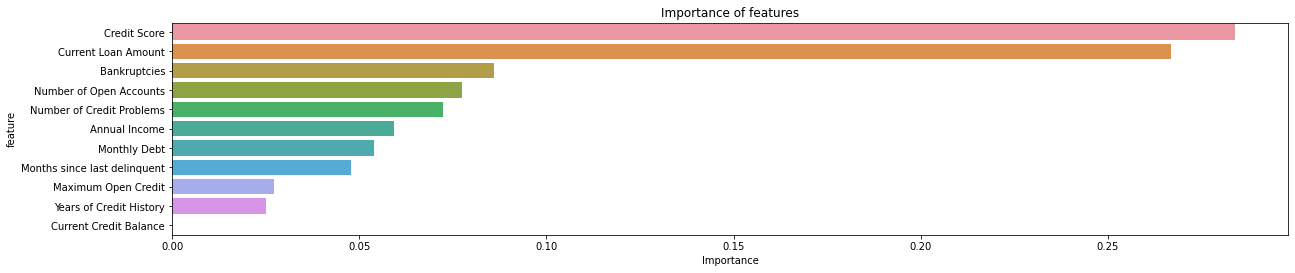

In [107]:
important_features_top = show_feature_importances(X_train_num.columns,
                                                  model_xgb_num.feature_importances_, get_top=19)

In [108]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Bankruptcies',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Annual Income',
 'Monthly Debt',
 'Months since last delinquent',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance']

In [109]:
# сохранить модель
import pickle
model_file = MODEL_PATH / ('model_xgb_num01.pkl')
with open(model_file, 'wb') as file:
    pickle.dump(model_xgb_num, file)